# Assignment 1: Bandits and Exploration/Exploitation

Bem-vindo à Tarefa 1. Este caderno irá:
- Ajude você a criar seu primeiro algoritmo de bandido
- Ajudar você a entender o efeito do épsilon na exploração e aprender sobre a compensação exploração/exploração
- Apresentar alguns dos softwares de aprendizagem por reforço que usaremos para esta especialização

Esta classe usa RL-Glue para implementar a maioria de nossos experimentos. Foi originalmente projetado por Adam White, Brian Tanner e Rich Sutton. Esta biblioteca lhe dará uma estrutura sólida para entender como funcionam os experimentos de aprendizagem por reforço e como executar os seus próprios. Se parecer um pouco confuso no início, não se preocupe – iremos orientá-lo lentamente e apresentar mais e mais partes à medida que você avança na especialização.

Presumimos que você já usou um notebook Jupyter antes. Mas se não, é bem simples. Basta pressionar o botão executar ou shift+enter para executar cada uma das células. Os locais do código que você precisa preencher estarão claramente marcados para você.

## Section 0: Preliminaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import sys

sys.path.append('/content/drive/MyDrive')

import environment
from rl_glue import RLGlue  # RLGlue para facilitar a interação entre o agente e o ambiente
import agent
import main_agent
import ten_arm_env
import test_env

Na célula acima, importamos as bibliotecas necessárias para esta tarefa. Usamos numpy ao longo do curso e ocasionalmente fornecemos dicas sobre quais métodos usar em numpy. Fora isso, usamos principalmente vanilla python e outras bibliotecas ocasionais, como matplotlib para fazer gráficos.

Você deve ter notado que importamos ten_arm_env. Este é o __10-armed Testbed__ apresentado na [seção 2.3](http://www.incompleteideas.net/book/RLbook2018.pdf) do livro didático. Usamos isso ao longo deste caderno para testar nossos agentes bandidos. Possui 10 braços, que são as ações que o agente pode realizar. Puxar um braço gera uma recompensa estocástica de uma distribuição gaussiana com variância unitária. Para cada ação, o valor esperado dessa ação é amostrado aleatoriamente a partir de uma distribuição normal, no início de cada execução. Se você não estiver familiarizado com o Testbed de 10 braços, revise-o no livro antes de continuar.

__NÃO IMPORTE OUTRAS BIBLIOTECAS, pois isso danificará o autonivelador.__

__NÃO DEFINE UMA SEMENTE ALEATÓRIA, pois isso quebrará o autonivelador.__

Por favor **não** duplique células. Isso colocará seu notebook em mau estado e quebrará o autonivelador de Cousera.

Antes de enviar, clique em "Kernel" -> "Reiniciar e executar tudo" e certifique-se de que todas as células sejam aprovadas.

## Section 1: Greedy Agent

Queremos criar um agente que encontre a ação com a maior recompensa esperada. Uma forma de um agente operar é sempre escolher a ação com o valor mais alto com base nas estimativas atuais do agente. Isso é chamado de agente ganancioso, pois escolhe avidamente a ação que considera ter o maior valor. Vejamos o que acontece neste caso.

Primeiro vamos implementar a função argmax, que pega uma lista de valores de ação e retorna uma ação com o valor mais alto. Por que estamos implementando a nossa própria função em vez de usar a função argmax que o numpy usa? A função argmax do Numpy retorna a primeira instância do valor mais alto. Não queremos que isso aconteça, pois influencia o agente a escolher uma ação específica no caso de empate. Em vez disso, queremos quebrar os laços entre os valores mais altos aleatoriamente. Então, vamos implementar nossa própria função argmax. Você pode consultar [np.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) para selecionar aleatoriamente em uma lista de valores.

In [3]:
def argmax(q_values):
    """
    Pega uma lista de q_values e retorna o índice do item
    com o valor mais alto. Quebra os laços aleatoriamente.
    retorna: int - o índice do valor mais alto em q_values
    """

    top_value = float("-inf")
    ties = []

    for i in range(len(q_values)):
        # Se um valor em q_values for maior que o valor mais alto, atualize top_value e redefina os empates
        if q_values[i] > top_value:
            top_value = q_values[i]
            ties = [i]

        # Se um valor for igual ao valor superior, adicione o índice aos empates
        elif q_values[i] == top_value:
            ties.append(i)

    # Retorna uma seleção aleatória de empates
    return np.random.choice(ties)

In [4]:
test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Verificando se a implementação argmax retorna o índice do maior valor"

np.random.seed(0)
test_array = [1, 0, 0, 1]

assert argmax(test_array) == 0

In [5]:
test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Verificando se a implementação argmax retorna o índice do maior valor"

# define a semente aleatória para que os resultados sejam determinísticos
np.random.seed(0)
test_array = [1, 0, 0, 1]

counts = [0, 0, 0, 0]
for _ in range(100):
    a = argmax(test_array)
    counts[a] += 1

# certifique-se de que argmax nem sempre escolha a primeira entrada
assert counts[0] != 100, "Certifique-se de que sua implementação argmax escolha aleatoriamente entre os maiores valores."

# make sure argmax does not always choose last entry
assert counts[3] != 100, "Certifique-se de que sua implementação argmax escolha aleatoriamente entre os maiores valores."

# certifique-se de que o gerador de números aleatórios seja chamado exatamente uma vez sempre que `argmax` for chamado
expected = [44, 0, 0, 56] # <-- observe que não é perfeitamente uniforme devido à aleatoriedade
assert counts == expected

Agora apresentamos a primeira parte de um agente RL-Glue que você implementará. Aqui vamos criar um GreedyAgent e implementar o método agent_step. Este método é chamado cada vez que o agente dá uma etapa. O método deve retornar a ação selecionada pelo agente. Este método também garante que as estimativas do agente sejam atualizadas com base nos sinais que recebe do ambiente.

Preencha o código abaixo para implementar um agente ganancioso.

In [6]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation=None):
      """
      Dá um passo para o agente. É preciso uma recompensa e observação e
      retorna a ação que o agente escolhe naquele intervalo de tempo.

      Argumentos:
      reward - float, a recompensa que o agente recebeu do ambiente após realizar a última ação.
      observation -- float, o estado observado em que o agente se encontra. Não se preocupe com isso, pois você não o usar
      até aulas futuras
      Retorna:
      current_action -- int, a ação escolhida pelo agente no intervalo de tempo atual.
      """

      ### Variáveis de classe úteis ###
      # self.q_values: Um array com o que o agente acredita ser cada um dos valores do braço
      # self.arm_count : Um array com uma contagem do número de vezes que cada braço foi puxado
      # self.last_action: A ação que o agente executou no intervalo de tempo anterior
      #######################
      # Atualize os valores Q Dica: observe o algoritmo na seção 2.4 do livro

      # incrementa o contador em self.arm_count para a ação do intervalo de tempo anterior
      # atualize o tamanho do passo usando self.arm_count
      self.arm_count[self.last_action] += 1

      # Calcula a taxa de aprendizado (alpha) como 1/n, onde n é o número de vezes que a ação foi tomada
      alpha = 1.0 / self.arm_count[self.last_action]

      # Atualiza o valor Q para a ação do intervalo de tempo anterior
      self.q_values[self.last_action] += alpha * (reward - self.q_values[self.last_action])

      # Escolhe a ação com o maior valor Q (greedy policy)
      current_action = argmax(self.q_values)

      # Atualiza last_action para a ação atual
      self.last_action = current_action

      return current_action

In [7]:
# Construa um agente falso para teste e defina algumas condições iniciais

np.random.seed(1)
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 0.5, 0, 0] # array com o que o agente acredita ser cada um dos valores do braço
greedy_agent.arm_count = [0, 1, 0, 0, 0] # número de vezes que cada braço foi puxado
greedy_agent.last_action = 1

action = greedy_agent.agent_step(reward=1)

# certifique-se de que q_values foram atualizados corretamente
assert greedy_agent.q_values == [0, 0.5, 0.5, 0, 0]

# certifique-se de que o agente esteja usando o argmax que desempata aleatoriamente
assert action == 2

In [8]:
# construa um agente falso para teste e defina algumas condições iniciais
np.random.seed(1)
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0] # array com o que o agente acredita ser cada um dos valores do braço
greedy_agent.arm_count = [0, 1, 0, 0, 0] # número de vezes que cada braço foi puxado
greedy_agent.last_action = 1

# dê um passo de agente falso
action = greedy_agent.agent_step(reward=1)

# certifique-se de que o agente tomou medidas gananciosas
assert action == 2

# certifique-se de que q_values foram atualizados corretamente
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

# dê mais um passo
action = greedy_agent.agent_step(reward=2)
assert action == 2
assert greedy_agent.q_values == [0, 0.5, 2.0, 0, 0]

Vamos visualizar o resultado. Aqui realizamos um experimento usando RL-Glue para testar nosso agente. Por enquanto, configuraremos o código do experimento; em lições futuras, orientaremos você na execução de experimentos para que você possa criar os seus próprios.

In [9]:
num_runs = 200 # O número de vezes que vamos executar o experimento
num_steps = 1000  # O número de puxadas de cada braço que o agente realiza
env = ten_arm_env.Environment # Definimos o ambiente
agent = GreedyAgent # Nós escolhemos qual agente queremos usar
agent_info = {"num_actions": 10}  # Passamos ao agente as informações que ele necessita. Aqui quantos braços existem.
env_info = {} # Passamos ao ambiente as informações que ele precisa. Neste caso nada.

In [10]:
rewards = np.zeros((num_runs, num_steps))
average_best = 0

In [11]:
for run in tqdm(range(num_runs)): # tqdm é o que cria a barra de progresso
    np.random.seed(run)

    rl_glue = RLGlue(env, agent) # Cria um novo experimento RLGlue com o ambiente e agente que escolhemos acima
    rl_glue.rl_init(agent_info, env_info) # Passamos ao RLGlue o que ele precisa para inicializar o agente e o ambiente
    rl_glue.rl_start() # Iniciamos o experimento

    average_best += np.max(rl_glue.environment.arms)

    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # O ambiente e o agente dão um passo e voltam
                                                 # a recompensa e as medidas tomadas.
        rewards[run, i] = reward

100%|██████████| 200/200 [00:10<00:00, 18.19it/s]


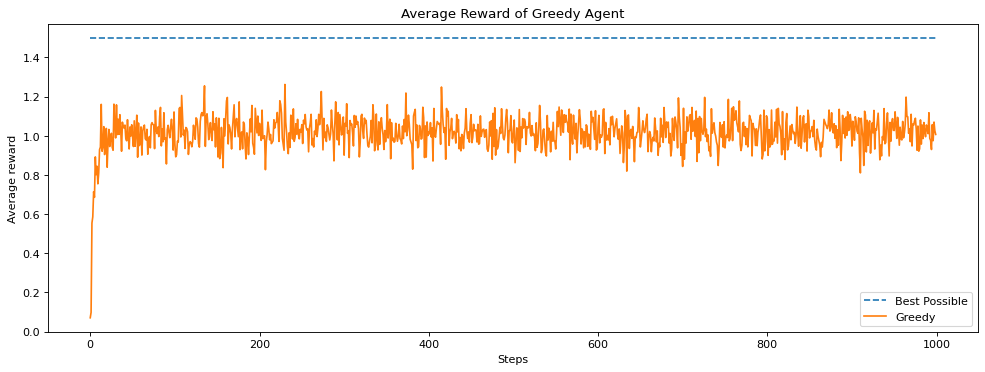

In [12]:
greedy_scores = np.mean(rewards, axis=0)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

How did our agent do? Is it possible for it to do better?

## Section 2: Epsilon-Greedy Agent

Aprendemos sobre [outra maneira de um agente operar](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/lecture/tHDck/what-is-the-trade-off), onde nem sempre toma medidas gananciosas. Em vez disso, às vezes é necessária uma ação exploratória. Ele faz isso para descobrir qual é realmente a melhor ação. Se sempre escolhermos o que pensamos ser a melhor ação atual, poderemos perder a oportunidade de realizar a melhor ação verdadeira, porque não exploramos tempos suficientes para encontrar a melhor ação.

Implemente um agente ganancioso épsilon abaixo. Dica: estamos implementando o algoritmo da [seção 2.4](http://www.incompleteideas.net/book/RLbook2018.pdf#page=52) do livro didático. Você pode querer usar seu código ganancioso acima e dar uma olhada em [np.random.random](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.random.html), também como [np.random.randint](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html), para ajudá-lo a selecionar ações aleatórias.

In [13]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
      """
      Dá um passo para o agente. É preciso uma recompensa e observação e
      retorna a ação que o agente escolhe naquele intervalo de tempo.

      Argumentos:
      recompensa - float, a recompensa que o agente recebeu do ambiente após realizar a última ação.
      observação -- float, o estado observado em que o agente se encontra. Não se preocupe com isso, pois você não o usará
                            até aulas futuras
      Retorna:
      current_action -- int, a ação escolhida pelo agente no intervalo de tempo atual.
      """

      ### Variáveis de classe úteis ###
      # self.q_values: Um array com o que o agente acredita ser cada um dos valores do braço.
      # self.arm_count : Um array com uma contagem do número de vezes que cada braço foi puxado.
      # self.last_action: A ação que o agente executou no intervalo de tempo anterior
      # self.epsilon : A probabilidade de um agente ganancioso épsilon explorar (varia entre 0 e 1)
      #######################

      # Atualize os valores Q - esta deve ser a mesma atualização do seu agente ganancioso acima
      # seu código aqui

      # Escolha a ação usando o epsilon ganancioso
      # Escolha aleatoriamente um número entre 0 e 1 e veja se é menor que self.epsilon

      # (dica: veja np.random.random()). Se for, defina current_action como uma ação interrogada.
      # caso contrário, escolha current_action avidamente como você fez acima

      if self.last_action is not None: # verifica se existe uma ação anterior
        self.arm_count[self.last_action] += 1 # aumenta o contador da ação que foi escolhida na última rodada
        self.q_values[self.last_action] += (reward - self.q_values[self.last_action]) / self.arm_count[self.last_action]

      # Escolhe a ação usando epsilon-greedy
      if np.random.random() < self.epsilon: # Se esse número for menor que epsilon
        # Exploração: escolha uma ação aleatória
        current_action = np.random.choice(len(self.q_values))
      else:
        # Exploração: escolha a melhor ação conhecida
        current_action = argmax(self.q_values)

      self.last_action = current_action

      return current_action

In [14]:
np.random.seed(0)

# Q-values for each action
q_values = [0, 0, 0.5, 0, 0]
print(f"Q-values \n{q_values}\n")

# Number of times each action has been chosen
arm_count = [0, 1, 0, 0, 0]
print(f"arm_count \n{arm_count}\n")

# Index of the last action chosen
last_action = 1
arm_count[last_action] += 1
print(f"arm_count \n{arm_count}\n")
# Reward received
reward = 1

# Exploration rate
epsilon = 0.5

# Generate a random number
n = np.random.random()
print(f"N: {n}\n")

# Update the Q-value for the last action
q_values[last_action] += (reward - q_values[last_action]) / arm_count[last_action]

if n < epsilon:
    print("n menor que epsilon\n")
    # Choose a random action
    current_action = np.random.choice(len(q_values))
else:
    print("n maior que epsilon\n")
    # Choose the action with the highest Q-value
    current_action = argmax(q_values)


print(f"current action: {current_action}\n")

print(f"last_action antigo: {last_action}")
last_action = current_action
print(f"last_action novo: {last_action}\n")

print(f"Q-values \n{q_values}")

print(f"\narm_count \n{arm_count}")

Q-values 
[0, 0, 0.5, 0, 0]

arm_count 
[0, 1, 0, 0, 0]

arm_count 
[0, 2, 0, 0, 0]

N: 0.5488135039273248

n maior que epsilon

current action: 2

last_action antigo: 1
last_action novo: 2

Q-values 
[0, 0.5, 0.5, 0, 0]

arm_count 
[0, 2, 0, 0, 0]


In [15]:
# construa um agente falso para teste e defina algumas condições iniciais
np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0, 0.5, 0, 0] # Um array com o que o agente acredita ser cada um dos valores do braço
e_greedy_agent.arm_count = [0, 1, 0, 0, 0] # Um array com uma contagem do número de vezes que cada braço foi puxado
e_greedy_agent.last_action = 1 # A ação que o agente executou no intervalo de tempo anterior
e_greedy_agent.epsilon = 0.5 # A probabilidade de um agente ganancioso épsilon explorar (varia entre 0 e 1)

# Dada esta semente aleatória, devemos ver uma ação gananciosa (ação 2) aqui

action = e_greedy_agent.agent_step(reward=1, observation=0)

#----------------------------------------------------------
# Tentaremos adivinhar alguns dos lugares mais complicados
#----------------------------------------------------------

# Certifique-se de atualizar para *last_action* e não para a ação atual
assert e_greedy_agent.q_values != [0, 0.5, 1.0, 0, 0], "A"

# Certifique-se de atualizar para *last_action* e não para a ação atual
assert e_greedy_agent.q_values != [0, 1, 0.5, 0, 0], "B"

# Certifique-se de que o agente esteja usando o argmax que desempate aleatoriamente
assert action == 2, "C"

In [16]:
# Vamos ver o que acontece com outra ação
np.random.seed(1)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0.5, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5

# Dada esta semente aleatória, devemos ver uma ação aleatória (ação 4) aqui
action = e_greedy_agent.agent_step(reward=1, observation=0)

# O agente recebeu uma recompensa de 1, então deve aumentar o valor de *last_action*
assert e_greedy_agent.q_values == [0, 0.75, 0.5, 0, 0], "D"

# o agente deveria ter escolhido uma ação aleatória para esta semente aleatória específica
assert action == 4, "E"

In [17]:
np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent()
e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.num_actions = 5
e_greedy_agent.last_action = 1
e_greedy_agent.epsilon = 0.5
action = e_greedy_agent.agent_step(reward=1, observation=0)

assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

#manipule a semente aleatória para que o agente execute uma ação aleatória
np.random.seed(1)
action = e_greedy_agent.agent_step(reward=0, observation=0)

assert action == 4

# verifique se atualizamos o valor da ação 4
action = e_greedy_agent.agent_step(reward=1, observation=0)
assert e_greedy_agent.q_values == [0, 0.5, 0.0, 0, 1.0]

Agora que criamos nosso agente ganancioso épsilon. Vamos compará-lo com o agente ganancioso com épsilon de 0,1.

100%|██████████| 200/200 [00:12<00:00, 16.27it/s]


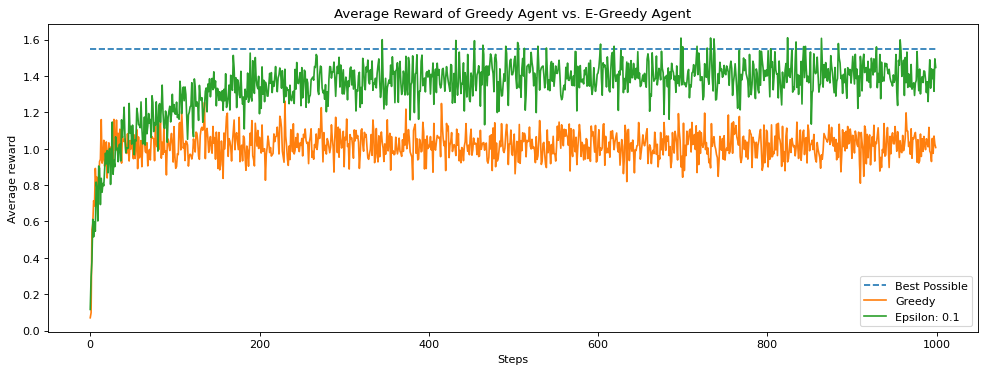

In [18]:
# Plotar resultados gananciosos e resultados gananciosos do Epsilon
num_runs = 200 # O número de vezes que vamos executar o experimento
num_steps = 1000  # O número de puxadas de cada braço que o agente realiza
epsilon = 0.1 # taxa de aleatoriedade
agent = EpsilonGreedyAgent # Nós escolhemos qual agente queremos usar
env = ten_arm_env.Environment # Definimos o ambiente
agent_info = {"num_actions": 10, "epsilon": epsilon} # Passamos ao agente as informações que ele necessita. Aqui quantos braços existem e epsilon
env_info = {} # Passamos ao ambiente as informações que ele precisa. Neste caso nada
all_rewards = np.zeros((num_runs, num_steps))

for run in tqdm(range(num_runs)):
    np.random.seed(run)

    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # O ambiente e o agente dão um passo e devolvem
                                                 # a recompensa e as ações tomadas.
        all_rewards[run, i] = reward

# calcule a média das corridas
scores = np.mean(all_rewards, axis=0)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. E-Greedy Agent")
plt.plot(scores)
plt.legend(("Best Possible", "Greedy", "Epsilon: 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Observe como o agente ganancioso do épsilon se saiu muito melhor. Como ocasionalmente escolhemos uma acção aleatória, conseguimos encontrar uma política melhor a longo prazo. Ao agirmos avidamente antes que as nossas estimativas de valor sejam precisas, corremos o risco de nos decidirmos por uma ação abaixo do ideal.

## Section 2.1 Averaging Multiple Runs

Você notou que tivemos uma média de mais de 200 execuções? Por que fizemos isso?

Para ter uma ideia, vejamos os resultados de duas execuções individuais do mesmo agente.

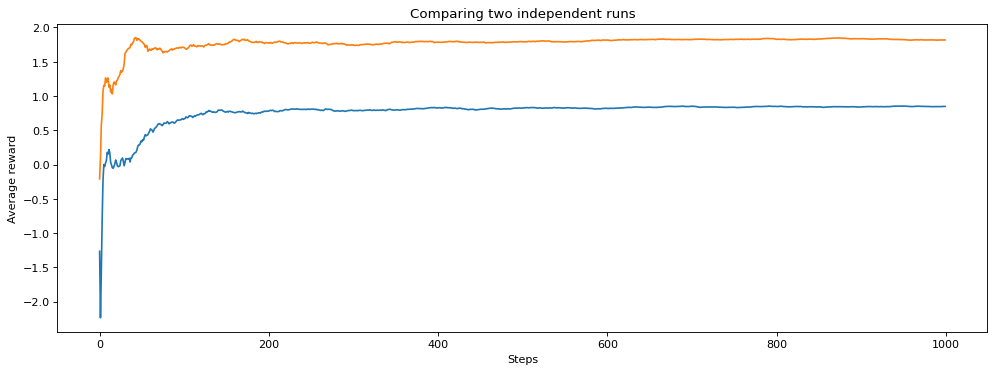

In [19]:
# Plotar execuções de agente e-ganancioso
agent = EpsilonGreedyAgent  # Nós escolhemos qual agente queremos usar
env = ten_arm_env.Environment # Definimos o ambiente

# Passamos ao agente as informações que ele necessita. Aqui quantos braços existem e epsilon
agent_info = {"num_actions": 10, "epsilon": 0.1}

# Passamos ao ambiente as informações que ele precisa. Neste caso nada.
env_info = {}

# O número de puxadas de cada braço que o agente realiza
num_steps = 1000

plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')  # Configuração da figura para o gráfico

for run in (0, 1):
    np.random.seed(run)  # Aqui definimos a semente para que possamos comparar duas execuções diferentes
    averages = []  # Lista para armazenar as recompensas médias para cada execução
    rl_glue = RLGlue(env, agent)  # Inicializamos a interface RLGlue com o ambiente e o agente
    rl_glue.rl_init(agent_info, env_info)  # Inicializamos o agente e o ambiente com suas respectivas informações
    rl_glue.rl_start()  # Iniciamos o episódio

    scores = [0]  # Lista para armazenar os scores cumulativos
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()  # Executamos um passo no ambiente
        scores.append(scores[-1] + reward)  # Atualizamos o score cumulativo com a nova recompensa
        averages.append(scores[-1] / (i + 1))  # Calculamos a recompensa média até o passo atual

    plt.plot(averages)  # Plotamos a recompensa média para esta execução

plt.title("Comparing two independent runs")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Observe como as duas execuções foram diferentes? Mas, se este é exatamente o mesmo algoritmo, por que ele se comporta de maneira diferente nessas duas execuções?

A resposta é que isso se deve à aleatoriedade no ambiente e no agente. Dependendo da ação com a qual o agente inicia aleatoriamente ou de quando escolhe explorar aleatoriamente, ele pode alterar os resultados das execuções. E mesmo que o agente escolha a mesma ação, a recompensa do ambiente é amostrada aleatoriamente a partir de uma Gaussiana. O agente poderia ter sorte e obter recompensas maiores pela melhor ação desde o início e, assim, decidir pela melhor ação mais rapidamente. Ou pode ter azar e ver recompensas menores pela melhor ação desde o início e, assim, levar mais tempo para reconhecer que é de fato a melhor ação.

Para ser mais concreto, vejamos quantas vezes uma ação exploratória é realizada, para diferentes sementes.

In [20]:
# ---------------
# Discussion Cell
# ---------------
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")

print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Exploratory Action")

Random Seed 1
Exploratory Action
Exploratory Action
Exploratory Action

Random Seed 2
Exploratory Action


Com a primeira semente, realizamos uma ação exploratória três vezes em 15, mas com a segunda, realizamos uma ação exploratória apenas uma vez. Isto pode afetar significativamente o desempenho do nosso agente porque a quantidade de exploração mudou significativamente.

Para comparar algoritmos, portanto, relatamos a média do desempenho em muitas execuções. Fazemos isso para garantir que não estamos simplesmente relatando um resultado devido à estocasticidade, conforme explicado [nas palestras](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/lecture/PtVBs /tomada de decisão sequencial com feedback avaliativo). Em vez disso, queremos resultados estatisticamente significativos. Não usaremos testes de significância estatística neste curso. Em vez disso, como temos acesso a simuladores para os nossos experimentos, usamos a estratégia mais simples de executar um grande número de execuções e garantir que os intervalos de confiança não se sobreponham.

## Section 3: Comparing values of epsilon

Podemos fazer melhor do que um épsilon de 0,1? Vamos tentar vários valores diferentes para épsilon e ver como eles funcionam. Tentamos diferentes configurações dos principais parâmetros de desempenho para entender como o agente pode funcionar sob diferentes condições.

Abaixo, executamos um experimento onde varremos diferentes valores para épsilon:

100%|██████████| 200/200 [00:07<00:00, 26.96it/s]


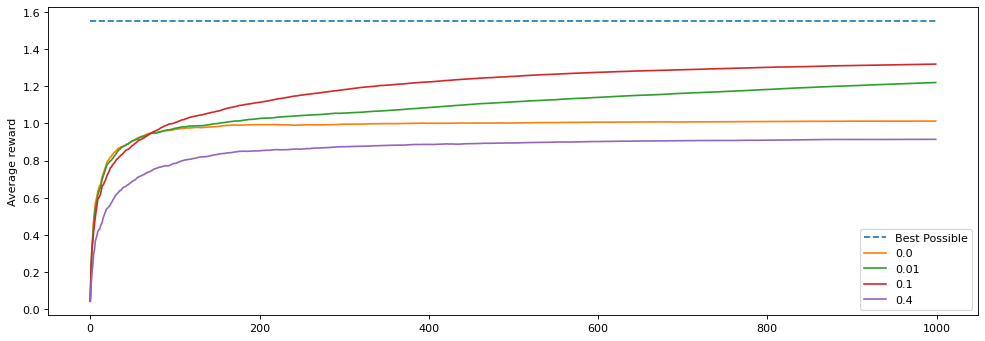

In [21]:
# Código experimental para diferentes epsilon-greedy agents
epsilons = [0.0, 0.01, 0.1, 0.4]  # Diferentes valores de epsilon para testar

plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')  # Configuração da figura para o gráfico
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")  # Plotar linha de referência para o melhor valor possível

n_q_values = []  # Lista para armazenar os valores Q para epsilon
n_averages = []  # Lista para armazenar as recompensas médias para epsilon
n_best_actions = []  # Lista para armazenar a contagem de ações ótimas escolhidas para epsilon

num_runs = 200  # Número de execuções para cada valor de epsilon

for epsilon in epsilons:
    all_averages = []  # Lista para armazenar as recompensas médias de todas as execuções para o epsilon atual
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent  # Inicializa o agente epsilon-greedy
        agent_info = {"num_actions": 10, "epsilon": epsilon}  # Informações do agente
        env_info = {"random_seed": run}  # Informações do ambiente, usando a semente da execução atual

        rl_glue = RLGlue(env, agent)  # Inicializa a interface RLGlue com o ambiente e o agente
        rl_glue.rl_init(agent_info, env_info)  # Inicializa o agente e o ambiente com suas respectivas informações
        rl_glue.rl_start()  # Inicia o episódio

        best_arm = np.argmax(rl_glue.environment.arms)  # Identifica o melhor braço no ambiente

        scores = [0]  # Lista para armazenar os scores cumulativos
        averages = []  # Lista para armazenar as recompensas médias para a execução atual
        best_action_chosen = []  # Lista para armazenar se a melhor ação foi escolhida em cada passo

        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()  # Executa um passo no ambiente
            scores.append(scores[-1] + reward)  # Atualiza o score cumulativo com a nova recompensa
            averages.append(scores[-1] / (i + 1))  # Calcula a recompensa média até o passo atual
            if action == best_arm:
                best_action_chosen.append(1)  # Registra se a melhor ação foi escolhida
            else:
                best_action_chosen.append(0)  # Registra se a melhor ação não foi escolhida
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))  # Armazena os valores Q para análise posterior

        if epsilon == 0.1:
            n_averages.append(averages)  # Armazena as recompensas médias para epsilon = 0.1
            n_best_actions.append(best_action_chosen)  # Armazena as escolhas das melhores ações para epsilon = 0.1
        all_averages.append(averages)  # Armazena as recompensas médias para todas as execuções

    plt.plot(np.mean(all_averages, axis=0))  # Plota a média das recompensas médias para o epsilon atual

plt.legend(["Best Possible"] + epsilons)
plt.ylabel("Average reward")
plt.show()

Por que 0,1 teve melhor desempenho que 0,01?

Se a exploração ajuda, por que o 0,4 teve um desempenho pior que o 0,0 (o agente ganancioso)?

Pense sobre isso e como você responderia a essas perguntas. São perguntas do questionário prático. Se você ainda tiver dúvidas sobre isso, refaça o teste prático.

## Section 4: The Effect of Step Size

Na Seção 1 desta tarefa, diminuímos o tamanho do passo ao longo do tempo com base nas contagens de seleção de ações. O tamanho do passo foi 1/N(A), onde N(A) é o número de vezes que a ação A foi selecionada. Isso é o mesmo que calcular uma média amostral. Também poderíamos definir o tamanho do passo como um valor constante, como 0,1. Qual seria o efeito de fazer isso? E é melhor usar uma constante ou o método da média amostral?

Para investigar esta questão, vamos começar criando um novo agente que tenha um tamanho de passo constante. Isso será quase idêntico ao agente criado acima. Você usará o mesmo código para selecionar a ação gananciosa épsilon. Você alterará a atualização para ter um tamanho de passo constante em vez de usar a atualização 1/N(A).

In [22]:
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
         Dá um passo para o agente. É preciso uma recompensa e observação e
         retorna a ação que o agente escolhe naquele intervalo de tempo.

         Argumentos:
         recompensa - float, a recompensa que o agente recebeu do ambiente após realizar a última ação.
         observação -- float, o estado observado em que o agente se encontra. Não se preocupe com isso, pois você não o usará
                               até aulas futuras
         Retorna:
         current_action -- int, a ação escolhida pelo agente no intervalo de tempo atual.
         """

         ### Variáveis de classe úteis ###
         # self.q_values: Um array com o que o agente acredita ser cada um dos valores do braço.
         # self.arm_count : Um array com uma contagem do número de vezes que cada braço foi puxado.
         # self.last_action : Um inteiro da ação que o agente executou no intervalo de tempo anterior.
         # self.step_size: um float que é o tamanho atual do passo do agente.
         # self.epsilon : A probabilidade de um agente ganancioso épsilon explorar (varia entre 0 e 1)
         #######################

         # Atualiza q_values para ações tomadas na etapa anterior
         # usando self.step_size em vez de usar self.arm_count
         # seu código aqui

         # Escolha a ação usando o épsilon ganancioso. É o mesmo que você implementou acima.
         # seu código aqui
        self.epsilon = 0.5
        if self.last_action is not None:
            self.q_values[self.last_action] += self.step_size * (reward - self.q_values[self.last_action])

        # Seleciona a próxima ação com base na política gananciosa (ou seja, escolhe a ação com maior valor Q)
        if np.random.uniform(0, 1) < self.epsilon:  # Exploração ocasional
            next_action = np.random.randint(0, self.num_actions - 1)  # Escolhe aleatoriamente uma ação
        else:
            next_action = argmax(self.q_values)  # Escolhe a ação com maior valor Q

        self.last_action = next_action  # Atualiza a última ação
        return next_action

        self.last_action = current_action

        return current_action

In [24]:
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size
    action = e_greedy_agent.agent_step(1, 0)
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Verifique se você está atualizando q_values corretamente usando o tamanho do passo."

In [25]:
np.random.seed(0)
# Verifique o Epsilon Greedy com diferentes tamanhos de passos constantes
for step_size in [0.01, 0.1, 0.5, 1.0]:
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize()
    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.num_actions = 5
    e_greedy_agent.last_action = 1
    e_greedy_agent.epsilon = 0.0
    e_greedy_agent.step_size = step_size

    action = e_greedy_agent.agent_step(1, 0)

    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0]

In [ ]:
# Código experimental para diferentes tamanhos de passo
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']  # Diferentes valores de tamanho de passo para testar

epsilon = 0.1  # Valor de epsilon para a política epsilon-greedy
num_steps = 1000  # Número de passos em cada execução
num_runs = 200  # Número de execuções independentes para cada tamanho de passo

fig, ax = plt.subplots(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')  # Configuração da figura para o gráfico

# Dicionários para armazenar valores Q, valores verdadeiros dos braços e porcentagem de melhores ações escolhidas
q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []  # Lista para armazenar as recompensas médias de todas as execuções para o tamanho de passo atual
    for run in tqdm(range(num_runs)):
        np.random.seed(run)  # Definir a semente para reprodutibilidade
        # Escolher o agente apropriado com base no tamanho de passo
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}  # Informações do agente
        env_info = {}  # Informações do ambiente

        rl_glue = RLGlue(env, agent)  # Inicializa a interface RLGlue com o ambiente e o agente
        rl_glue.rl_init(agent_info, env_info)  # Inicializa o agente e o ambiente com suas respectivas informações
        rl_glue.rl_start()  # Inicia o episódio

        best_arm = np.argmax(rl_glue.environment.arms)  # Identifica o melhor braço no ambiente

        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)  # Armazena os valores verdadeiros dos braços na primeira execução

        best_action_chosen = []  # Lista para armazenar se a melhor ação foi escolhida em cada passo
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()  # Executa um passo no ambiente
            if action == best_arm:
                best_action_chosen.append(1)  # Registra se a melhor ação foi escolhida
            else:
                best_action_chosen.append(0)  # Registra se a melhor ação não foi escolhida
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))  # Armazena os valores Q para análise posterior

        best_actions[step_size].append(best_action_chosen)  # Armazena as escolhas das melhores ações para cada execução
    ax.plot(np.mean(best_actions[step_size], axis=0))  # Plota a média das melhores ações escolhidas para o tamanho de passo atual

plt.legend(step_sizes)
plt.title("% Best Arm Pulled")
plt.xlabel("Steps")
plt.ylabel("% Best Arm Pulled")
vals = ax.get_yticks()  # Obtém os valores dos ticks do eixo Y
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])  # Formata os ticks do eixo Y como porcentagem
plt.show()

 52%|█████▎    | 105/200 [00:03<00:03, 30.56it/s]

Observe primeiro que agora estamos traçando o período de tempo em que a melhor ação é realizada, em vez da recompensa média. Para compreender melhor o desempenho de um agente, pode ser útil medir comportamentos específicos, além de quanta recompensa é acumulada. Esta medida indica quão próximo o comportamento do agente está do ideal.

Parece que 1/N(A) teve um desempenho melhor que os outros, pois chega a uma solução onde executa a melhor ação com mais frequência. Agora, por que isso pode acontecer? Por que um passo de 0,5 começou melhor, mas acabou tendo um desempenho pior? Por que um tamanho de passo de 0,01 teve um desempenho tão ruim?

Vamos aprofundar isso mais abaixo. Vamos representar graficamente o quão bem cada agente rastreia o valor verdadeiro, onde cada agente tem um método de tamanho de passo diferente. Você não precisa inserir nenhum código aqui, apenas siga em frente.

In [ ]:
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

Esses gráficos ajudam a esclarecer as diferenças de desempenho entre os diferentes tamanhos de passo. Um tamanho de passo de 0,01 faz atualizações tão pequenas que a estimativa de valor da melhor ação do agente não chega perto do valor real. Os tamanhos de passo de 0,5 e 1,0 aproximam-se rapidamente do valor real, mas são muito suscetíveis à estocasticidade nas recompensas. As atualizações corrigem demais as recompensas recentes e, portanto, oscilam em torno do valor real. Isso significa que, em muitas etapas, a ação que puxa o melhor braço pode parecer pior do que realmente é.   Um tamanho de passo de 0,1 é atualizado rapidamente para o valor verdadeiro e não oscila tão amplamente em torno dos valores verdadeiros como 0,5 e 1,0. Esta é uma das razões pelas quais 0.1 funciona muito bem. Finalmente vemos por que 1/N(A) teve um bom desempenho. No início, enquanto o tamanho do passo ainda é razoavelmente alto, ele se move rapidamente para o verdadeiro valor esperado, mas à medida que é puxado mais, o tamanho do passo é reduzido, o que o torna menos suscetível à estocasticidade das recompensas.

Isso significa que 1/N(A) é sempre o melhor? Quando pode não ser? Um cenário possível onde pode não ser tão eficaz é em problemas não estacionários. Você aprendeu sobre não estacionariedade nas lições. A não estacionariedade significa que o ambiente pode mudar com o tempo. Isso pode se manifestar como uma mudança contínua do ambiente ao longo do tempo ou uma mudança repentina no ambiente.

Vejamos como uma mudança repentina nas distribuições de recompensa afeta um tamanho de passo como 1/N(A). Desta vez, executaremos o ambiente por 2.000 etapas e, após 1.000 etapas, alteraremos aleatoriamente o valor esperado de todos os braços. Comparamos dois agentes, ambos usando épsilon-greedy com épsilon = 0,1. Um usa um tamanho de passo constante de 0,1, o outro um tamanho de passo de 1/N(A) que diminui com o tempo.

100%|██████████| 500/500 [00:30<00:00, 16.60it/s]


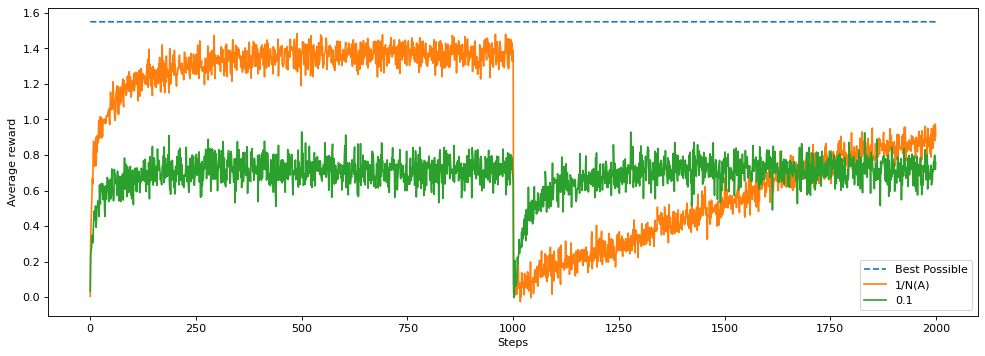

In [28]:
epsilon = 0.1  # Valor de epsilon para a política epsilon-greedy
num_steps = 2000  # Número de passos em cada execução
num_runs = 500  # Número de execuções independentes para cada agente
step_size = 0.1  # Tamanho de passo para atualização do valor Q

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')  # Configuração da figura para o gráfico
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")  # Linha de referência para o melhor resultado possível

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:  # Testar dois agentes diferentes
    rewards = np.zeros((num_runs, num_steps))  # Inicializar matriz para armazenar recompensas

    for run in tqdm(range(num_runs)):  # Loop sobre o número de execuções
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}  # Informações do agente
        np.random.seed(run)  # Definir a semente para reprodutibilidade

        rl_glue = RLGlue(env, agent)  # Inicializa a interface RLGlue com o ambiente e o agente
        rl_glue.rl_init(agent_info, env_info)  # Inicializa o agente e o ambiente com suas respectivas informações
        rl_glue.rl_start()  # Inicia o episódio

        for i in range(num_steps):  # Loop sobre o número de passos
            reward, state, action, is_terminal = rl_glue.rl_step()  # Executa um passo no ambiente
            rewards[run, i] = reward  # Armazena a recompensa

            if i == 1000:  # No passo 1000, muda os valores dos braços
                rl_glue.environment.arms = np.random.randn(10)  # Redefine os valores dos braços

    plt.plot(np.mean(rewards, axis=0))  # Plota a média das recompensas sobre todas as execuções

plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Agora, o agente com um tamanho de passo de 1/N(A) teve um desempenho melhor no início, mas depois teve um desempenho pior quando o ambiente mudou! O que aconteceu?

Pense em qual seria o tamanho do passo após 1.000 passos. Digamos que a melhor ação seja escolhida 500 vezes. Isso significa que o tamanho do passo para essa ação é 1/500 ou 0,002. A cada passo quando atualizamos o valor da ação e o valor vai se mover apenas 0,002* o erro. Esse é um ajuste muito pequeno e levará muito tempo para chegar ao valor real.

O agente com tamanho de passo 0,1, entretanto, sempre atualizará em 1/10 da direção do erro. Isso significa que, em média, serão necessários dez passos para atualizar seu valor para a média amostral.

Esses são os tipos de compensações em que devemos pensar na aprendizagem por reforço. Um tamanho de passo maior nos move mais rapidamente em direção ao valor verdadeiro, mas pode fazer com que nossos valores estimados oscilem em torno do valor esperado. Um tamanho de passo que reduz ao longo do tempo pode convergir para próximo do valor esperado, sem oscilar. Por outro lado, um tamanho de degrau tão decadente não é capaz de se adaptar às mudanças no ambiente. A não estacionariedade – e o conceito relacionado de observabilidade parcial – é uma característica comum dos problemas de aprendizagem por reforço e quando se aprende online.

## Section 5: Conclusion

Ótimo trabalho! Você tem:
- Implementou seu primeiro agente
- Aprendeu sobre o efeito do épsilon, um parâmetro de exploração, no desempenho de um agente
- Aprendeu sobre o efeito do tamanho do passo no desempenho do agente
- Aprendi sobre uma boa prática experimental de calcular a média de várias execuções